In [1]:
from scipy import *
from numpy import *
from scipy import optimize
from matplotlib import pyplot as plt


In [2]:
def loadDatasets(lfn, intensityCutoff):
    datasets=[loadtxt(fn) for fn in lfn]
    # Columns: frame, x, y, nan, intensity, ...

    fig,ax=plt.subplots(1,2,figsize=(6,2.5))

    plt.sca(ax[0])
    plt.axhline(intensityCutoff,c='lightgray',zorder=0)
    #plt.yscale('log');
    plt.xlabel("Time (frame)"); plt.ylabel("Fluo. (a.u.)"); plt.title('Raw')
    plt.sca(ax[1]);
    plt.xlabel("x (px)++"); plt.ylabel("y (px)"); plt.title('Raw')
    plt.gca().set_aspect('equal', 'datalim')

    for d in datasets:
        ax[0].plot(d[:,0],d[:,4])
        sel=where(d[:,4]>intensityCutoff)[0]
        ax[1].plot(d[sel,1],d[sel,2])

    plt.tight_layout()
    plt.show()
    
    return datasets

In [3]:
def subtractBallistic(datasets, intensityCutoff):
    datasets2=[]
    # Columns: frame (centered), x (centered), y (centered), mask, fluo, x (centered, drift subtracted), y (centered, drift subtracted)

    ### Center traces
    for d in datasets:
        f0=d[:,4].argmax(); fMax=d.shape[0]

        frame=r_[:fMax]-fMax//2
        xy   =roll(d[:,1:3]-d[f0,1:3],fMax//2-f0,0)
        fluo =roll(d[:,4]            ,fMax//2-f0,0)

        mask=(fluo>intensityCutoff)*1
        xy=(xy.T*mask).T

        datasets2.append(c_[frame,xy,mask,fluo,xy])

    datasets2=array(datasets2)

    ### Calculate, fit and subtract ballistic motion
    xy_mean_weight=sum(datasets2[:,:,3],0)
    xy_mean=(sum(datasets2[:,:,1:3],0).T/(xy_mean_weight+1e-20*(xy_mean_weight==0))).T
    sel=where(xy_mean_weight)[0]
    fit=polyfit(frame[sel],xy_mean[sel],deg=1,w=xy_mean_weight[sel])
    xy_fit=dot(c_[frame,frame*0+1],fit)
    for i in range(datasets2.shape[0]): datasets2[i,:,5:7]=((datasets2[i,:,5:7]-xy_fit).T*datasets2[i,:,3]).T

    #--------------------
    fig,ax=plt.subplots(2,4,figsize=(12,5))

    plt.sca(ax[0,0])
    plt.axhline(intensityCutoff,c='lightgray',zorder=0)
    plt.xlim(-40,40); plt.xlabel("Time (frame)"); plt.ylabel("Fluo. (a.u.)"); plt.title('Centered')
    plt.sca(ax[0,1]); plt.xlabel("x (px)"); plt.ylabel("y (px)"); plt.title('Centered'); plt.gca().set_aspect('equal', 'datalim')
    plt.sca(ax[0,2]); plt.xlabel("Time (frame)"); plt.ylabel("x (px)"); plt.title('Centered')
    plt.sca(ax[0,3]); plt.xlabel("Time (frame)"); plt.ylabel("y (px)"); plt.title('Centered')
    plt.sca(ax[1,1]); plt.xlabel("x (px)"); plt.ylabel("y (px)"); plt.title('Corrected'); plt.gca().set_aspect('equal', 'datalim')
    plt.sca(ax[1,2]); plt.xlabel("Time (frame)"); plt.ylabel("x (px)"); plt.title('Corrected');
    plt.sca(ax[1,3]); plt.xlabel("Time (frame)"); plt.ylabel("y (px)"); plt.title('Corrected');

    for d in datasets2:
        ax[0,0].plot(d[:,0],d[:,4])
        sel=where(d[:,3])[0]
        ax[0,1].plot(d[sel,1],d[sel,2])
        ax[0,2].plot(d[sel,0],d[sel,1])
        ax[0,3].plot(d[sel,0],d[sel,2])
        ax[1,1].plot(d[sel,5],d[sel,6])
        ax[1,2].plot(d[sel,0],d[sel,5])
        ax[1,3].plot(d[sel,0],d[sel,6])

    sel=where(xy_mean_weight>=3)[0]
    ax[0,1].plot(xy_mean[sel,0],xy_mean[sel,1],c='k',lw=4)
    ax[0,1].plot(xy_fit[sel,0], xy_fit[sel,1], c='r',lw=3)
    ax[0,2].plot(frame[sel],xy_mean[sel,0],c='k',lw=4)
    ax[0,2].plot(frame[sel],xy_fit[sel,0], c='r',lw=3)
    ax[0,3].plot(frame[sel],xy_mean[sel,1],c='k',lw=4)
    ax[0,3].plot(frame[sel],xy_fit[sel,1], c='r',lw=3)

    ax[1,0].axis('off')
    plt.tight_layout()
    plt.show()

    return datasets2


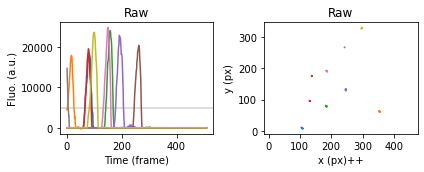

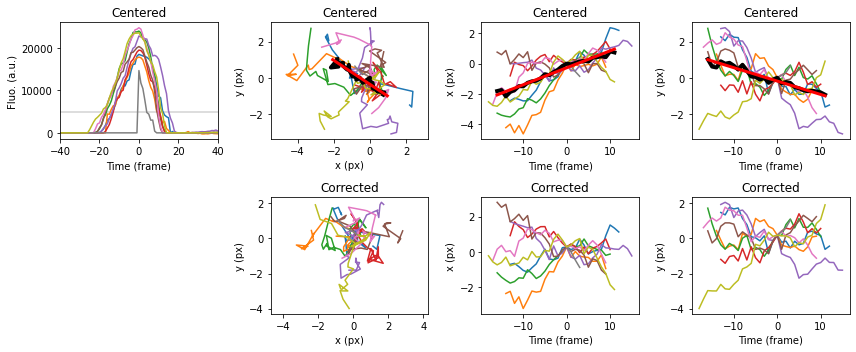

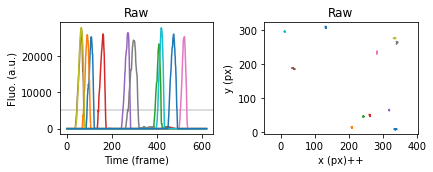

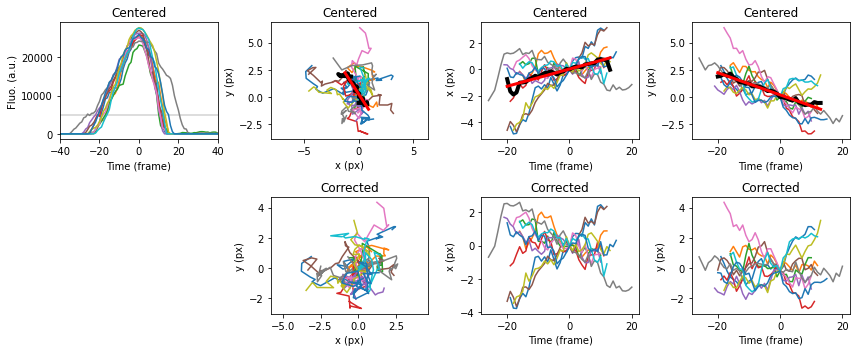

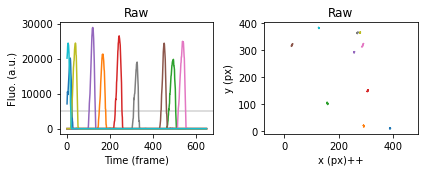

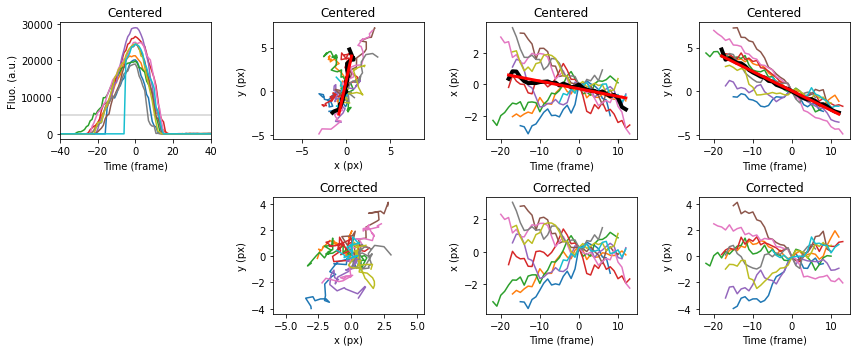

In [4]:
pxSize=0.5385033     # um/px
dt=0.25              # sec

intensityCutoff=5000 # adu

allDatasets=[]
datasets=loadDatasets(['20211208__forDiffusion_translight_3_scale0.2_blur1px_subtr1000_bead01.trk2',
                       '20211208__forDiffusion_translight_3_scale0.2_blur1px_subtr1000_bead02.trk2',
                       '20211208__forDiffusion_translight_3_scale0.2_blur1px_subtr1000_bead03.trk2',
                       '20211208__forDiffusion_translight_3_scale0.2_blur1px_subtr1000_bead04.trk2',
                       '20211208__forDiffusion_translight_3_scale0.2_blur1px_subtr1000_bead05.trk2',
                       '20211208__forDiffusion_translight_3_scale0.2_blur1px_subtr1000_bead06.trk2',
                       '20211208__forDiffusion_translight_3_scale0.2_blur1px_subtr1000_bead07.trk2',
                       '20211208__forDiffusion_translight_3_scale0.2_blur1px_subtr1000_bead08.trk2',
                       '20211208__forDiffusion_translight_3_scale0.2_blur1px_subtr1000_bead09.trk2',
                       ], intensityCutoff)
datasets2=subtractBallistic(datasets, intensityCutoff)
allDatasets.append(datasets2)

datasets=loadDatasets(['20211208__forDiffusion_diluted_translight_2_scale0.2_blur1px_subtr1000_bead01.trk2',
                       '20211208__forDiffusion_diluted_translight_2_scale0.2_blur1px_subtr1000_bead02.trk2',
                       '20211208__forDiffusion_diluted_translight_2_scale0.2_blur1px_subtr1000_bead03.trk2',
                       '20211208__forDiffusion_diluted_translight_2_scale0.2_blur1px_subtr1000_bead04.trk2',
                       '20211208__forDiffusion_diluted_translight_2_scale0.2_blur1px_subtr1000_bead05.trk2',
                       #'20211208__forDiffusion_diluted_translight_2_scale0.2_blur1px_subtr1000_bead06.trk2',
                       '20211208__forDiffusion_diluted_translight_2_scale0.2_blur1px_subtr1000_bead07.trk2',
                       '20211208__forDiffusion_diluted_translight_2_scale0.2_blur1px_subtr1000_bead08.trk2',
                       '20211208__forDiffusion_diluted_translight_2_scale0.2_blur1px_subtr1000_bead09.trk2',
                       '20211208__forDiffusion_diluted_translight_2_scale0.2_blur1px_subtr1000_bead10.trk2',
                       '20211208__forDiffusion_diluted_translight_2_scale0.2_blur1px_subtr1000_bead11.trk2',
                       '20211208__forDiffusion_diluted_translight_2_scale0.2_blur1px_subtr1000_bead12.trk2',
                       #'20211208__forDiffusion_diluted_translight_2_scale0.2_blur1px_subtr1000_bead13.trk2', # Tracking issues
                       ], intensityCutoff)
datasets2=subtractBallistic(datasets, intensityCutoff)
allDatasets.append(datasets2)

datasets=loadDatasets(['20211208__forDiffusion_diluted_translight_3_scale0.2_blur1px_subtr1000_bead01.trk2',
                       '20211208__forDiffusion_diluted_translight_3_scale0.2_blur1px_subtr1000_bead02.trk2',
                       '20211208__forDiffusion_diluted_translight_3_scale0.2_blur1px_subtr1000_bead03.trk2',
                       '20211208__forDiffusion_diluted_translight_3_scale0.2_blur1px_subtr1000_bead04.trk2',
                       '20211208__forDiffusion_diluted_translight_3_scale0.2_blur1px_subtr1000_bead05.trk2',
                       '20211208__forDiffusion_diluted_translight_3_scale0.2_blur1px_subtr1000_bead06.trk2',
                       '20211208__forDiffusion_diluted_translight_3_scale0.2_blur1px_subtr1000_bead07.trk2',
                       '20211208__forDiffusion_diluted_translight_3_scale0.2_blur1px_subtr1000_bead08.trk2',
                       '20211208__forDiffusion_diluted_translight_3_scale0.2_blur1px_subtr1000_bead09.trk2',
                       '20211208__forDiffusion_diluted_translight_3_scale0.2_blur1px_subtr1000_bead10.trk2',
                       ], intensityCutoff)
datasets2=subtractBallistic(datasets, intensityCutoff)
allDatasets.append(datasets2)

allDatasets=concatenate([r_[ds.swapaxes(0,1),zeros((700-ds.shape[1],ds.shape[0],ds.shape[2]))].swapaxes(0,1)
                                                                               for ds in allDatasets])


<ipython-input-5-89bbc75bf2cc>:12: RuntimeWarning: invalid value encountered in true_divide
  msds=[c_[a[:,0]/a[:,1] *pxSize**2 ,a[:,1]]for a in res]


Optimization terminated successfully.
         Current function value: 134.090058
         Iterations: 27
         Function evaluations: 54
n = 30


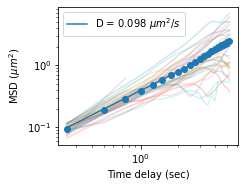

In [5]:
iMax=22
iMaxFit=10

res=[]
for d in allDatasets:
    mask=d[:,3]
    xy=d[:,5:7]
    res.append(array([
        #  Summed square displacement,                         Weight
        [  sum(((xy[i:]-xy[:-i]).T**2)*(mask[i:]*mask[:-i])),  sum(mask[i:]*mask[:-i])  ]
                                               for i in range(1,iMax)]))
msds=[c_[a[:,0]/a[:,1] *pxSize**2 ,a[:,1]]for a in res]

res=array(res).sum(0)
msd=res[:,0]/res[:,1] *pxSize**2

tau=r_[1:iMax] *dt

fit=optimize.fmin(lambda p: sum(((p*tau[:iMaxFit]-msd[:iMaxFit])*res[:iMaxFit,1])**2),2*2.e-3)

plt.figure(figsize=(3.5,2.7))
for a in msds: plt.plot(tau,a[:,0],zorder=0,alpha=.2)    
plt.scatter(tau,msd,marker='o')
plt.plot(tau,fit*tau, label='D = %.3f $\mu m^2/s$'%(fit/4))
plt.xscale('log'); plt.yscale('log')
#plt.ylim(-.5,3.5)
plt.xlabel('Time delay (sec)'); plt.ylabel('MSD ($\mu m^2$)')
plt.legend()
plt.tight_layout()
#plt.show()
plt.savefig('fig_MSD_beads.pdf')

print('n = %d'%(allDatasets.shape[0]))
